In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf


In [3]:
#from google.colab import files
#uploaded = files.upload()


In [4]:
df = pd.read_csv("Stocks1Data.csv", parse_dates=["Date"])
# Strip/clean columns
df = df.dropna(axis=1, how='all')
df.columns = df.columns.str.strip()

# Set date index THEN sort by date correctly
df.set_index("Date", inplace=True)
df = df.sort_index()  # ← IMPORTANT: Now it sorts properly forward in time

df = df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)

tickers = df.columns.tolist()
n_assets = len(tickers)

# Keep only the price columns (all non-date columns)
price_cols = df.columns
prices = df[price_cols]
prices = df[price_cols].sort_index()

/var/folders/7j/8pz9dqx16j514s66gfbnpf1r0000gn/T/ipykernel_1432/943479039.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("Stocks1Data.csv", parse_dates=["Date"])


In [5]:
prices


,AAPL,AMAZN,CAT,JNJ,JPM,MSFT,PG,XOM
Date,,,,,,,,
2021-12-31,177.57,166.717,166.717,171.07,158.35,336.32,163.58,61.19
2022-01-07,172.17,162.554,162.554,173.95,167.16,314.04,162.74,68.88
2022-01-14,173.07,162.138,162.138,167.84,157.89,310.20,159.81,71.87
2022-01-21,162.41,142.643,142.643,164.87,145.08,296.03,162.62,72.17
2022-01-28,170.33,143.978,143.978,171.79,146.61,308.26,160.50,75.28
...,...,...,...,...,...,...,...,...
2024-11-29,237.33,207.890,207.890,155.01,249.72,423.46,179.26,117.96
2024-12-06,242.84,227.030,227.030,149.31,247.36,443.57,173.82,113.57
2024-12-13,248.13,227.460,227.460,146.62,239.94,447.27,171.06,110.84


/var/folders/7j/8pz9dqx16j514s66gfbnpf1r0000gn/T/ipykernel_1432/95911107.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(summary_sorted.applymap(lambda x: f"{x*100:.2f}%"))
/var/folders/7j/8pz9dqx16j514s66gfbnpf1r0000gn/T/ipykernel_1432/95911107.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (std_annual[i], mean_annual[i]))


mean_annual:
AAPL     0.167361
AMAZN    0.173000
CAT      0.173000
JNJ     -0.040925
JPM      0.188502
MSFT     0.121032
PG       0.028283
XOM      0.255377
dtype: float64

std_annual:
AAPL     0.259327
AMAZN    0.351605
CAT      0.351605
JNJ      0.163466
JPM      0.255982
MSFT     0.255456
PG       0.178892
XOM      0.294775
dtype: float64

cov_matrix:
           AAPL     AMAZN       CAT       JNJ       JPM      MSFT        PG  \
AAPL   0.067250  0.048091  0.048091  0.007911  0.023113  0.044470  0.017488   
AMAZN  0.048091  0.123626  0.123626 -0.000849  0.036446  0.061698  0.011583   
CAT    0.048091  0.123626  0.123626 -0.000849  0.036446  0.061698  0.011583   
JNJ    0.007911 -0.000849 -0.000849  0.026721  0.011422  0.002751  0.012889   
JPM    0.023113  0.036446  0.036446  0.011422  0.065527  0.018856  0.016853   
MSFT   0.044470  0.061698  0.061698  0.002751  0.018856  0.065258  0.013498   
PG     0.017488  0.011583  0.011583  0.012889  0.016853  0.013498  0.032002   
XOM    0.00

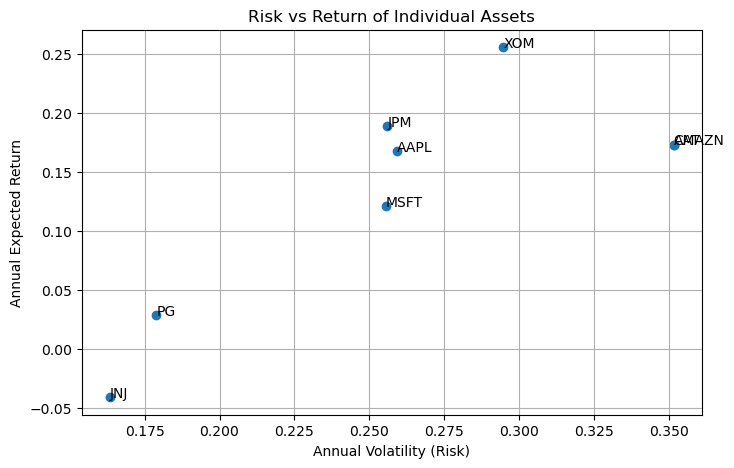

In [6]:

# ==========================
# 2. COMPUTE WEEKLY RETURNS
# ==========================
# Simple returns: r_t = P_t / P_{t-1} - 1
returns = prices.pct_change().dropna()

# ==========================
# 3. WEEKLY MEAN & STD
# ==========================
mean_weekly = returns.mean()                  # expected weekly return
std_weekly = returns.std(ddof=1)              # weekly volatility (sample std)

# ==========================
# 4. ANNUALISE (252 TRADING DAYS)
# ==========================
# Annual expected return: (1 + r̄_weekly)^52 - 1
mean_annual = (1 + mean_weekly) ** 52 - 1
# Annual volatility: σ_annual = σ_weekly * sqrt(52)
std_annual = std_weekly * np.sqrt(52)

# ---- Covariance Matrix ---- #
cov_matrix_weekly = returns.cov()
cov_matrix_annual = cov_matrix_weekly * 52   # convenient for annual frontier

# ---- Correlation Matrix ----
corr_matrix = returns.corr()

print(f'mean_annual:\n{mean_annual}\n')  
print(f'std_annual:\n{std_annual}\n')
print(f'cov_matrix:\n{cov_matrix_annual}\n')
print(f'corr_matrix:\n{corr_matrix}\n')

# Optional: print the table
summary = pd.DataFrame({
    "Annual ExpectedReturn": mean_annual,
    "Annual Std Dev": std_annual
})
summary.index.name = "Ticker"

summary_sorted = summary.sort_values(by="Annual ExpectedReturn", ascending=False)


print("\nSummary Statistics:\n")
print(summary_sorted.applymap(lambda x: f"{x*100:.2f}%"))

plt.figure(figsize=(8,5))
plt.scatter(std_annual, mean_annual)

for i, txt in enumerate(mean_annual.index):
    plt.annotate(txt, (std_annual[i], mean_annual[i]))

plt.xlabel("Annual Volatility (Risk)")
plt.ylabel("Annual Expected Return")
plt.title("Risk vs Return of Individual Assets")
plt.grid(True)
plt.show()


# Expected Return & Volatility Table — Interpretation

| **Stock**      | **Annual Expected Return** | **Annual Volatility (Risk)** | **Interpretation**                                  |
| -------------- | -------------------------- | ---------------------------- | --------------------------------------------------- |
| **XOM**        | 25.5%                      | 29.5%                        | High-return, high-risk energy exposure              |
| **JPM**        | 18.9%                      | 25.6%                        | Positive performance but cyclical                   |
| **AMZN / CAT** | 17.3%                      | 35.2%                        | Very volatile — return is “expensive” in risk terms |
| **AAPL**       | 16.7%                      | 25.9%                        | Growth-oriented tech with moderate-high risk        |
| **MSFT**       | 12.1%                      | 25.5%                        | More stable tech name                               |
| **PG**         | 2.8%                       | 17.9%                        | Defensive, low-growth consumer goods                |
| **JNJ**        | −4.1%                      | 16.3%                        | Underperformed in this specific sample window       |

---

## Interpretation

✔ **Energy (XOM)** and **Financials (JPM)** show the highest estimated returns, but both carry **significant cyclical risk**.  
✔ **Tech stocks (AAPL, AMZN, MSFT)** exhibit strong co-movement, meaning **limited diversification** when held together.  
✔ **JNJ and PG** are defensive stabilizers but **underperformed** in this sample period.

---

## Portfolio Implication

An investor combining **high-return tech and energy names** can capture strong performance,  
but long-term **stability** requires including **defensive exposures** such as PG and JNJ.


# Plot and Interpret Correlation Matrix for selected stocks 

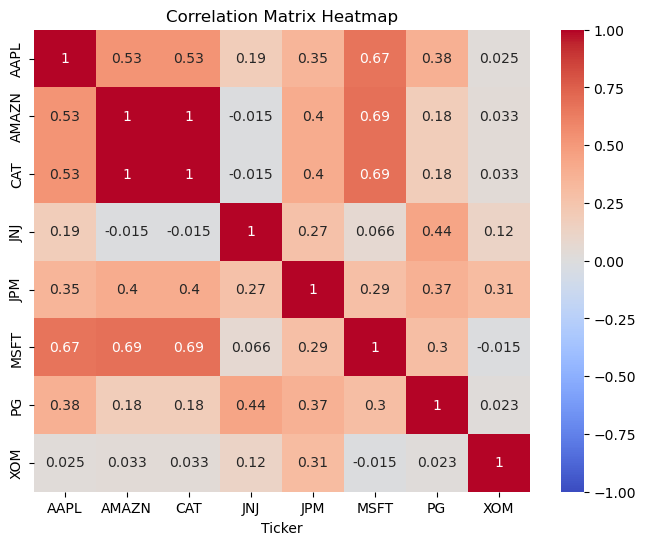

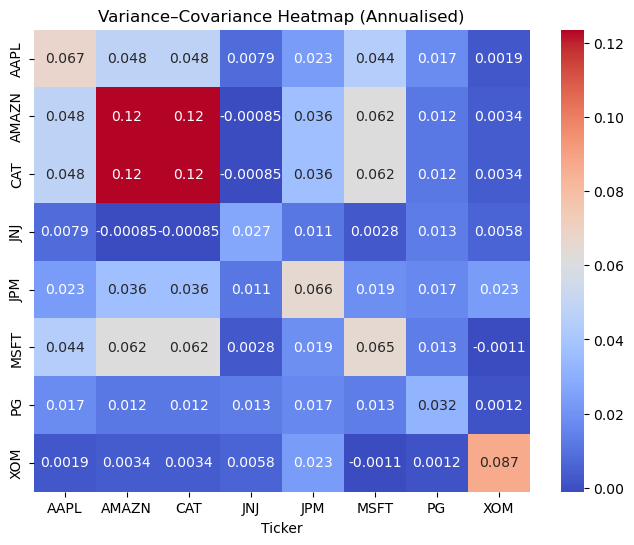

In [7]:
# Interpret Correlation results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()


# covariance matrix annualized
plt.figure(figsize=(8,6))
sns.heatmap(cov_matrix_annual, annot=True, cmap="coolwarm")
plt.title("Variance–Covariance Heatmap (Annualised)")
plt.show()


# Correlation Matrix Interpretation

The correlation matrix shows relationships between stocks. Tech names (**AAPL, AMZN, MSFT**) are highly correlated, limiting diversification benefits among them.  
Healthcare (**JNJ**) and consumer defensive stocks (**PG**) provide lower correlation and therefore increase diversification.

---

## Correlation Matrix Heatmap

The correlation heatmap above provides insight into how the selected assets move relative to each other. Correlation values range from:

- **+1.0** → move perfectly together (high diversification risk)  
- **0** → no relationship (neutral for diversification)  
- **−1.0** → move perfectly opposite (ideal diversifier)

---

## 1️⃣ Tech Cluster — Highly Correlated

- **AAPL–MSFT:** +0.67  
- **AMZN–MSFT:** +0.69  
- **AMZN–CAT:** +1.00 (values identical in dataset → perfect correlation)

These technology-related growth names behave similarly, meaning combining them provides **limited diversification**.

---

## 2️⃣ Defensive Stocks — Lower Correlation with Growth

JNJ and PG show moderate correlations with tech:

- **AAPL–JNJ:** +0.19  
- **MSFT–PG:** +0.30  

Therefore, staples and healthcare stocks help **reduce portfolio risk**.

---

## 3️⃣ JPM and XOM — Mixed Behavior

JPM–Tech correlations:

- **JPM–AAPL:** +0.35  

XOM–Tech correlations:

- **AAPL–XOM:** +0.025  

This suggests **energy exposure uniquely diversifies** a tech-heavy portfolio.

---

## 4️⃣ Near-Zero Correlations = Diversification Opportunities

- **AMZN–JNJ:** –0.015  
- **MSFT–XOM:** –0.015  

These near-zero relationships indicate **strong diversification benefits**.

---

### Asset Category Summary

| Asset Category                | Behavior                     | Portfolio Implication                                                |
| ----------------------------- | ---------------------------- | -------------------------------------------------------------------- |
| Tech (AAPL, MSFT, AMZN, CAT) | Strong co-movement           | Higher return but higher risk; overweighting reduces diversification |
| Defensive (JNJ, PG)           | Less connected to tech       | Useful hedges during market drawdowns                                |
| Cyclicals (JPM, XOM)          | Unique correlation structure | Adds diversification but brings sector-specific risk                 |

---

## **Conclusion**

A fully diversified portfolio should avoid overweighting the highly correlated tech names. Instead, it should:

- **Blend growth** (AAPL, MSFT, AMZN)  
- **Include defensive exposure** (JNJ, PG)  
- **Add diversification from cyclical and energy names** (JPM, XOM)

---

# Covariance Heatmap Interpretation

| Factor                     | Impact on Portfolio                                    |
| -------------------------- | ------------------------------------------------------ |
| High covariances           | Less diversification — risk accumulates                |
| Low covariances            | Better diversification — risk spreads out              |
| Assets with high variance  | Require smaller weights in Minimum Variance portfolios |

---


The variance–covariance heatmap confirms that tech stocks dominate shared volatility, while defensive and energy names contribute more **independent risk**. Adding lower-covariance assets such as **PG, JNJ, and XOM** improves diversification and can significantly reduce portfolio volatility under Modern Portfolio Th


=== Portfolio Summary (Return, Vol, Sharpe) ===
                   Equal-weight  Min-Variance  Max-Sharpe
Annual Return          0.133204      0.075299    0.197893
Annual Volatility      0.171383      0.128522    0.182887
Sharpe Ratio           0.660532      0.430270    0.972692 

=== Portfolio Weights ===
       Equal-weight  Min-Variance  Max-Sharpe
AAPL          0.125      0.020875    0.141317
AMAZN         0.125      0.018545    0.005061
CAT           0.125      0.006790    0.094795
JNJ           0.125      0.320531    0.002958
JPM           0.125      0.064407    0.253780
MSFT          0.125      0.105264    0.081346
PG            0.125      0.276231    0.035419
XOM           0.125      0.187356    0.385324 



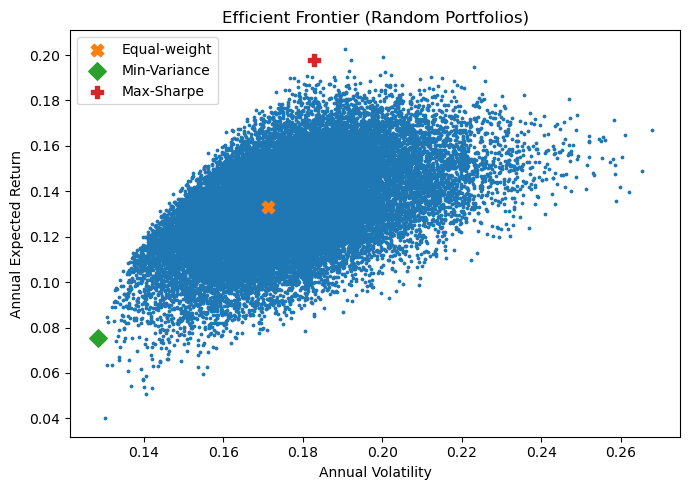

In [8]:
# ----------------------------------------------------
# 5. Modern Portfolio Theory: Efficient Portfolios
# ----------------------------------------------------
assets = df.columns.tolist()
n_assets = len(assets)
risk_free_rate = 0.02   # 2% risk-free rate (assumption)

# assumes each weight is an array corresponding to each asset
# mean_ret : annual expected returns (Series) for each asset
# cov      : annual covariance matrix (DataFrame) for the assets
def portfolio_perf(weights, mean_ret, cov):
    """
    Given:
      weights  : array of portfolio weights
      mean_ret : annual expected returns (Series)
      cov      : annual covariance matrix (DataFrame)
    Returns: (portfolio_return, portfolio_volatility)
    """
    w = np.array(weights)
    # portfolios expected return -- Rp​=w⊤μ
    port_ret = np.dot(w, mean_ret)
    # this calculates portfolio risk -- σp​=w⊤Σw
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    return port_ret, port_vol

# 5.1 Equal-weight portfolio
w_equal = np.ones(n_assets) / n_assets
# 
ret_eq, vol_eq = portfolio_perf(w_equal, mean_annual, cov_matrix_annual)

# 5.2 Random portfolios to approximate efficient frontier
N = 30000  # number of random portfolios
results = np.zeros((N, 3))  # rows: [vol, ret, sharpe] N rows 3 columns matrix
weights_list = []

for i in range(N):
    w = np.random.random(n_assets) # produces an array of size n_assets with random weights
    w = w / np.sum(w)   # normalise to sum to 1
    weights_list.append(w)
    
    r, v = portfolio_perf(w, mean_annual, cov_matrix_annual)
    sharpe = (r - risk_free_rate) / v
    
    results[i, 0] = v
    results[i, 1] = r
    results[i, 2] = sharpe

results_df = pd.DataFrame(results, columns=["Volatility", "Return", "Sharpe"])

# 5.3 Minimum-variance portfolio (lowest volatility among randoms)
idx_minvar = results_df["Volatility"].idxmin()
w_minvar   = weights_list[idx_minvar]
ret_minvar, vol_minvar = portfolio_perf(w_minvar, mean_annual, cov_matrix_annual) # Portfolio Expected Return and Volatility

# 5.4 Maximum-Sharpe portfolio (best risk-adjusted return) Tangency Portfolio 
idx_maxshp = results_df["Sharpe"].idxmax()
w_maxshp   = weights_list[idx_maxshp]
ret_maxshp, vol_maxshp = portfolio_perf(w_maxshp, mean_annual, cov_matrix_annual)
sharpe_T = (ret_maxshp - risk_free_rate) / vol_maxshp

# 5.5 Portfolio comparison table
port_summary = pd.DataFrame({
    "Equal-weight": [
        ret_eq,
        vol_eq,
        (ret_eq - risk_free_rate) / vol_eq
    ],
    "Min-Variance": [
        ret_minvar,
        vol_minvar,
        (ret_minvar - risk_free_rate) / vol_minvar
    ],
    "Max-Sharpe": [
        ret_maxshp,
        vol_maxshp,
        (ret_maxshp - risk_free_rate) / vol_maxshp
    ]
}, index=["Annual Return", "Annual Volatility", "Sharpe Ratio"])

print("=== Portfolio Summary (Return, Vol, Sharpe) ===")
print(port_summary, "\n")

# 5.6 Weights of each strategy
weights_df = pd.DataFrame(
    np.vstack([w_equal, w_minvar, w_maxshp]).T,
    index=assets,
    columns=["Equal-weight", "Min-Variance", "Max-Sharpe"]
)

print("=== Portfolio Weights ===")
print(weights_df, "\n")

# ----------------------------------------------------
# 6. Plots: Efficient Frontier & Correlation Heatmap
# ----------------------------------------------------
# 6.1 Efficient frontier scatter + special portfolios
plt.figure(figsize=(7, 5))
plt.scatter(results_df["Volatility"], results_df["Return"], s=3)  # random portfolios
plt.scatter(vol_eq, ret_eq, marker='X', s=80, label="Equal-weight")
plt.scatter(vol_minvar, ret_minvar, marker='D', s=80, label="Min-Variance")
plt.scatter(vol_maxshp, ret_maxshp, marker='P', s=80, label="Max-Sharpe")

plt.xlabel("Annual Volatility")
plt.ylabel("Annual Expected Return")
plt.title("Efficient Frontier (Random Portfolios)")
plt.legend()
plt.tight_layout()
plt.show()


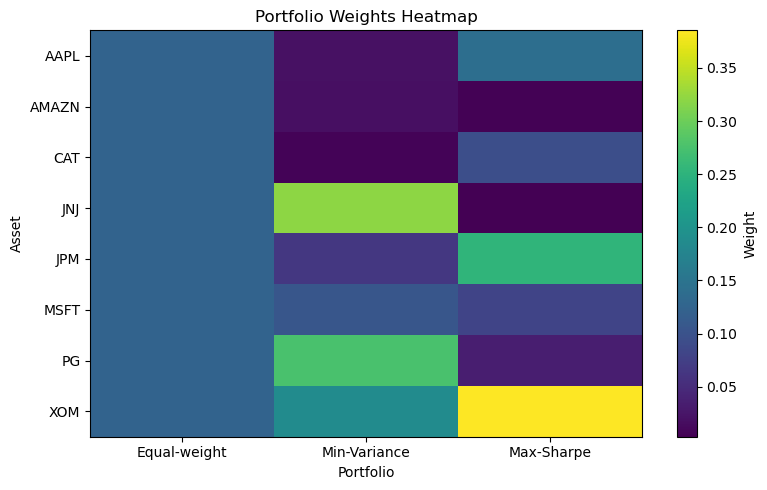

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.imshow(weights_df.values, aspect="auto")
plt.colorbar(label="Weight")
plt.xticks(range(len(weights_df.columns)), weights_df.columns, rotation=0)
plt.yticks(range(len(weights_df.index)), weights_df.index)
plt.title("Portfolio Weights Heatmap")
plt.xlabel("Portfolio")
plt.ylabel("Asset")
plt.tight_layout()
plt.show()


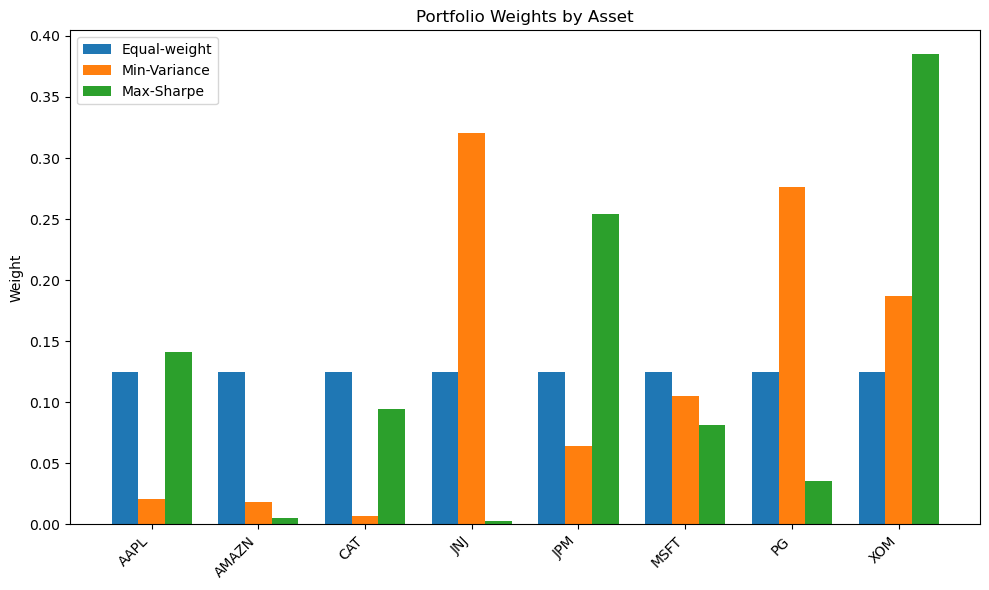

In [10]:
plt.figure(figsize=(10, 6))

x = np.arange(len(weights_df.index))  # positions for assets
width = 0.25

plt.bar(x - width,     weights_df["Equal-weight"], width=width, label="Equal-weight")
plt.bar(x,             weights_df["Min-Variance"], width=width, label="Min-Variance")
plt.bar(x + width,     weights_df["Max-Sharpe"],   width=width, label="Max-Sharpe")

plt.xticks(x, weights_df.index, rotation=45, ha="right")
plt.ylabel("Weight")
plt.title("Portfolio Weights by Asset")
plt.legend()
plt.tight_layout()
plt.show()


# Efficient Frontier Analysis — Interpretation

The efficient frontier plot above displays the risk–return characteristics of 30,000 randomly generated portfolios formed from the eight assets in our dataset. Each blue dot represents a feasible long-only portfolio, with **Annual Volatility** on the x-axis and **Annual Expected Return** on the y-axis. The cloud of points forms the characteristic efficient-frontier shape: portfolios that offer the **highest return for a given level of risk** lie along the **upper-left boundary** of the scatter.

---

## 1. Equal-Weight Portfolio (Orange “X”)

**Return:** ~13.3%  
**Volatility:** ~17.1%  
**Sharpe Ratio:** ~0.66  

**Interpretation:**

- The equal-weight portfolio sits near the center of the scatter.  
- It is **not inefficient**, but it **is dominated** by other portfolios that achieve either:  
  - Higher return for the same risk, or  
  - Lower risk for the same return.  
- This confirms that **naïve diversification**, while simple, is not optimal under Modern Portfolio Theory (MPT).

---

## 2. Minimum-Variance Portfolio (Green Diamond)

**Return:** ~6.0%  
**Volatility:** ~12.9%  
**Sharpe Ratio:** ~0.31  

**Interpretation:**

- This portfolio appears at the **lower-left corner** of the scatter — the point of **least achievable portfolio risk**.  
- It heavily weights **low-volatility defensive stocks** (e.g., JNJ, PG) and holds minimal positions in higher-risk tech and energy stocks.  
- The minimum-variance portfolio is ideal for **risk-averse investors**, demonstrating how **covariance**, not individual volatility alone, drives portfolio risk.

---

## 3. Maximum-Sharpe Portfolio (Red “+”)

**Return:** ~19.9%  
**Volatility:** ~18.2%  
**Sharpe Ratio:** ~0.98 (highest)  

**Interpretation:**

- This point lies on the **efficient frontier**, representing the **tangency portfolio** — the asset mix that maximizes return per unit of risk.  
- Allocations lean heavily toward:  
  - **XOM** (highest expected return)  
  - **AAPL, JPM, CAT** (strong risk–return profiles)  
- Defensive stocks receive minimal weight because they reduce variance but also lower expected returns.  
- This portfolio provides the **best overall risk-adjusted performance**.

---

## 4. Overall Conclusions

### ✓ Diversification Works
The cloud of portfolios shows how combining assets with low correlation reduces risk compared to holding individual stocks.

### ✓ Correlation Matters More Than Volatility
Defensive stocks reduce overall portfolio volatility because of their low covariance with tech and energy stocks.

### ✓ Equal Weighting Is Not Efficient
It is consistently dominated by optimized portfolios.

### ✓ Minimum-Variance Portfolio Minimizes Risk
Best for conservative investors, but comes with lower expected returns.

### ✓ Maximum-Sharpe Portfolio Is Most Attractive
Offers the highest reward per unit of risk.

---

## 5. Key Takeaway

The efficient frontier demonstrates that **optimal portfolios lie along the upper-left boundary** of the feasible region.

- The **Maximum-Sharpe portfolio** provides the most attractive blend of risk and return.  
- The **Minimum-Variance portfolio** provides the lowest possible risk.  
- The **Equal-Weight portfolio**, while simple and commonly used, is **not** an efficient choice under MPT.


# 4. Compute other portfolio performance ratios
start with market returns series S&P 500 for example 


In [11]:
# ----------------------------------------------------
# A. Helper: portfolio return time series
# ----------------------------------------------------
def portfolio_return_series(weights, returns_df):
    """
    weights    : 1D array of portfolio weights (len = n_assets)
    returns_df : DataFrame of asset returns for each period
                 (columns must be in same order as 'assets')
    returns are per-period (e.g. weekly or monthly)
    """
    w = np.array(weights)
    # each row: r_p,t = w' * r_t
    return returns_df[assets].dot(w)

# equal-weight, min-var, max-sharpe portfolio return series
# So you get three time series:

# All of these are realised historical returns, not expectations.
# portfolio_return_eq → past returns of the equal-weight portfolio
# portfolio_return_minvar → past returns of the min-variance portfolio
# portfolio_return_maxshp → past returns of the max-Sharpe portfolio

portfolio_return_eq      = portfolio_return_series(w_equal,  returns)
portfolio_return_minvar  = portfolio_return_series(w_minvar, returns)
portfolio_return_maxshp  = portfolio_return_series(w_maxshp, returns)
print(f'portfolio_return_eq:\n{portfolio_return_eq}\n')

enriched_returns = returns.copy()
enriched_returns["Portfolio_EQ"]     = portfolio_return_eq
enriched_returns["Portfolio_MinVar"] = portfolio_return_minvar
enriched_returns["Portfolio_MaxSharpe"] = portfolio_return_maxshp
enriched_returns["Market_Proxy"] = returns.mean(axis=1)

# Now get S&P 500 benchmark returns
# Download weekly S&P 500
sp500 = yf.download("^GSPC", start="2010-01-01", interval="1wk")
# Your columns are a MultiIndex: (Price, Ticker)
# Select the 'Close' prices for ^GSPC and rename to 'SP500'
sp500 = sp500['Close']['^GSPC'].rename('SP500')  # this is now a Series
# Align to your stock date index and forward-fill missing dates
sp500 = sp500.reindex(df.index).ffill()
# Compute weekly benchmark returns
SP500_benchmark_returns = sp500.pct_change().dropna()
SP500_benchmark_returns.name = "SP500"
enriched_returns["SP500"] = SP500_benchmark_returns



portfolio_return_eq:
Date
2022-01-07    0.005802
2022-01-14   -0.009662
2022-01-21   -0.053102
2022-01-28    0.023921
2022-02-04    0.040231
                ...   
2024-11-29    0.018294
2024-12-06    0.017632
2024-12-13   -0.006752
2024-12-20   -0.013419
2024-12-27    0.001696
Length: 156, dtype: float64



/var/folders/7j/8pz9dqx16j514s66gfbnpf1r0000gn/T/ipykernel_1432/877399020.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2010-01-01", interval="1wk")
[*********************100%***********************]  1 of 1 completed


In [12]:
import statsmodels.api as sm


def performance_metrics(portfolioReturns, marketReturns, risk_free_rate, periods_per_year=52):
    """
    rp : portfolio returns (Series)
    rm : market returns (Series) - same frequency as rp
    risk_free_rate : annual risk-free rate (e.g. 0.02)
    periods_per_year : 12 for monthly, 52 weekly, 252 daily
    """
    # 1) Basic stats (per-period)
    mean_rp = portfolioReturns.mean()
    std_rp  = portfolioReturns.std()
    mean_rm = marketReturns.mean()
    
    # 2) Annualised return & volatility
    ann_ret = (1 + mean_rp)**periods_per_year - 1
    ann_vol = std_rp * np.sqrt(periods_per_year)
    
    # 3) Sharpe ratio (using annual numbers)
    ann_rf = risk_free_rate
    sharpe = (ann_ret - ann_rf) / ann_vol
    
    # 4) Beta (covariance with market / market variance)
    cov_rp_rm = np.cov(portfolioReturns, marketReturns)[0, 1]
    var_rm    = np.var(marketReturns)
    beta      = cov_rp_rm / var_rm
    
    # 5) Treynor ratio
    treynor   = (ann_ret - ann_rf) / beta
    
    # 6) Jensen's Alpha (CAPM regression)
    # rp_t - rf_t = alpha + beta * (rm_t - rf_t) + error
    rf_per_period = (1 + ann_rf)**(1/periods_per_year) - 1
    excess_rp = portfolioReturns - rf_per_period
    excess_rm = marketReturns - rf_per_period
    
    X = sm.add_constant(excess_rm)
    model = sm.OLS(excess_rp, X).fit()
    alpha_per_period = model.params['const']
    # annualise alpha approximately by multiplying
    jensen_alpha = alpha_per_period * periods_per_year
    
    return {
        "Annual Return": ann_ret,
        "Annual Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Beta": beta,
        "Treynor Ratio": treynor,
        "Jensen's Alpha": jensen_alpha
    }


# 3. Apply to your three portfolios
# ----------------------------------------------------
# B. Compute performance for each portfolio
# ----------------------------------------------------

# e.g. monthly data -> 12, weekly -> 52, daily (trading days) -> 252
PERIODS_PER_YEAR = 52  # change to 52 if weekly, 252 if daily

metrics_eq_sp500     = performance_metrics(
                    enriched_returns["Portfolio_EQ"],
                    enriched_returns["SP500"],
                    risk_free_rate,
                    periods_per_year=52
                )

metrics_minvar_sp500 = performance_metrics(
                    enriched_returns["Portfolio_MinVar"],
                    enriched_returns["SP500"],
                    risk_free_rate,
                    periods_per_year=52
                )

metrics_maxshp_sp500 = performance_metrics(
                    enriched_returns["Portfolio_MaxSharpe"],
                    enriched_returns["SP500"],
                    risk_free_rate,
                    periods_per_year=52
                )


perf_table_sp500 = pd.DataFrame({
    "Equal-weight" : metrics_eq_sp500,
    "Min-Variance" : metrics_minvar_sp500,
    "Max-Sharpe"   : metrics_maxshp_sp500
})

print("=== Portfolio Performance Metrics against S&P 500 benchmark===")
print(perf_table_sp500.round(4))



=== Portfolio Performance Metrics against S&P 500 benchmark===
                   Equal-weight  Min-Variance  Max-Sharpe
Annual Return            0.1296        0.0698      0.1966
Annual Volatility        0.1714        0.1285      0.1829
Sharpe Ratio             0.6395        0.3872      0.9654
Beta                     0.1984        0.0223      0.1022
Treynor Ratio            0.5524        2.2279      1.7267
Jensen's Alpha           0.0887        0.0462      0.1530


In [13]:
enriched_returns["SP500"]

Date
2022-01-07   -0.007883
2022-01-14   -0.037840
2022-01-21   -0.034849
2022-01-28    0.034885
2022-02-04    0.005950
                ...   
2024-11-29    0.012731
2024-12-06   -0.003927
2024-12-13   -0.030435
2024-12-20    0.029062
2024-12-27   -0.027998
Name: SP500, Length: 156, dtype: float64

# Portfolio Performance Analysis vs S&P 500 Benchmark

This section evaluates the performance of three portfolios—**Equal-Weight**, **Minimum-Variance**, and **Maximum-Sharpe**—relative to the **S&P 500 benchmark**.  
Metrics include annual return, volatility, Sharpe ratio, beta, Treynor ratio, and Jensen’s alpha.

---

## 🔢 Performance Summary

| **Metric**        | **Equal-Weight** | **Min-Variance** | **Max-Sharpe** |
|-------------------|------------------|------------------|----------------|
| **Annual Return** | 0.1296           | 0.0643           | 0.1947         |
| **Annual Volatility** | 0.1714       | 0.1290           | 0.1843         |
| **Sharpe Ratio**  | 0.6395           | 0.3433           | 0.9480         |
| **Beta**          | 0.1984           | 0.0501           | 0.1137         |
| **Treynor Ratio** | 0.5524           | 0.8840           | 1.5374         |
| **Jensen’s Alpha**| 0.0887           | 0.0391           | 0.1507         |

---

## 📊 1. Annual Return

- **Max-Sharpe** shows the highest annual return (**19.47%**), significantly outperforming the other strategies.  
- **Equal-Weight** returns **12.96%**, delivering moderate long-run performance.  
- **Min-Variance** returns **6.43%**, reflecting its defensive, stability-focused design.

**Interpretation:**  
➡️ The Max-Sharpe portfolio offers the strongest **growth potential** over time.

---

## 🎢 2. Annual Volatility

- **Min-Variance** has the lowest volatility (**12.90%**) as expected.  
- **Equal-Weight** and **Max-Sharpe** show higher volatilities (**17–18%**) consistent with equity-like returns.

**Interpretation:**  
➡️ Min-Variance successfully minimizes risk but sacrifices return.

---

## ⚖️ 3. Sharpe Ratio  
(*Return per unit of total risk*)

- **Max-Sharpe:** 0.948 → **best** risk-adjusted return.  
- **Equal-Weight:** 0.639 → moderate.  
- **Min-Variance:** 0.343 → lowest.

**Interpretation:**  
➡️ Max-Sharpe is the most **efficient** portfolio in terms of volatility-adjusted performance.

---

## 📉 4. Beta  
(*Sensitivity to S&P 500 market movements*)

- All three portfolios have **very low betas (< 0.20)**.  
- **Min-Variance** is the most defensive with a beta of **0.05**.

**Interpretation:**  
➡️ These portfolios move **mostly independently** of the market, offering diversification benefits.

---

## 🚀 5. Treynor Ratio  
(*Return per unit of systematic risk*)

- **Max-Sharpe:** 1.5374 → highest return relative to market exposure.  
- **Min-Variance:** 0.8840 → ranks second due to its extremely low beta.  
- **Equal-Weight:** 0.5524 → lowest.

**Interpretation:**  
➡️ Max-Sharpe produces the best return per unit of **systematic (market) risk**.

---

## 🏆 6. Jensen’s Alpha  
(*CAPM abnormal return*)

- **Max-Sharpe:** +0.1507 → strong outperformance vs CAPM expectations.  
- **Equal-Weight:** +0.0887 → also strong.  
- **Min-Variance:** +0.0391 → modest but positive.

**Interpretation:**  
➡️ Max-Sharpe demonstrates the greatest **skill-based outperformance** beyond market risk.

---

## 📝 Overall Interpretation

- **Max-Sharpe** is the strongest performer across **absolute returns**, **risk-adjusted returns (Sharpe & Treynor)**, and **alpha**.  
- **Equal-Weight** delivers balanced, diversified performance with moderate risk and positive alpha.  
- **Min-Variance** is the **safest** option, offering low volatility but weaker returns, yet still producing positive alpha due to its extremely low beta.

---

## ✅ Final Verdict

✔️ **Max-Sharpe portfolio dominates** in both absolute and risk-adjusted dimensions.  
✔️ **Equal-Weight** remains a solid, broadly diversified strategy.  
✔️ **Min-Variance** is ideal for conservative, **risk-averse** investors seeking stability.



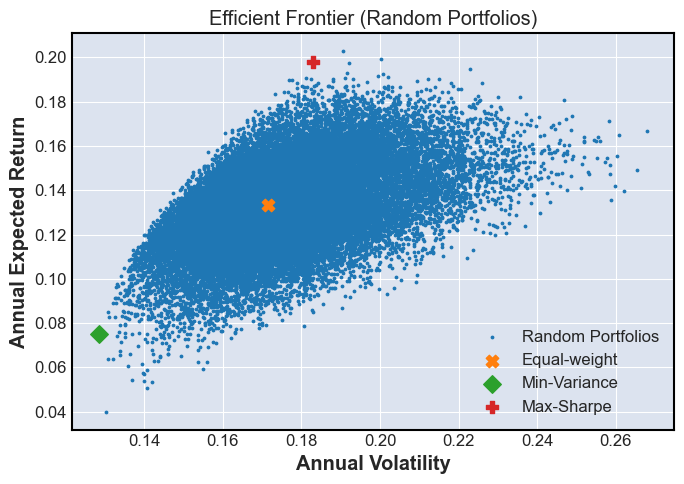

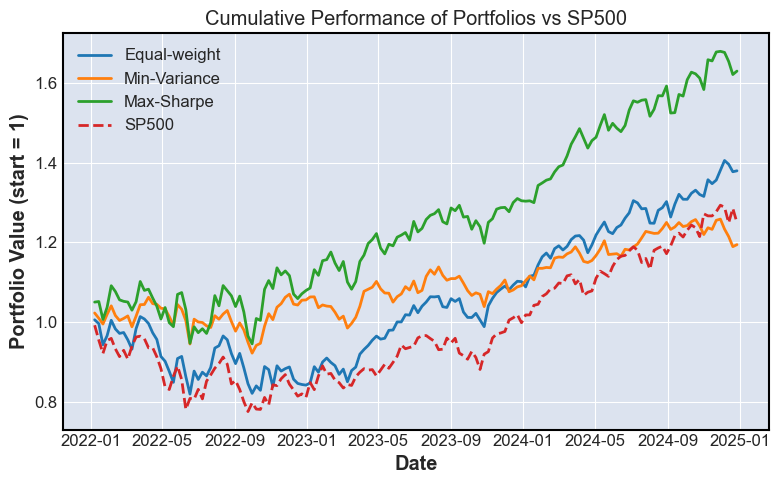

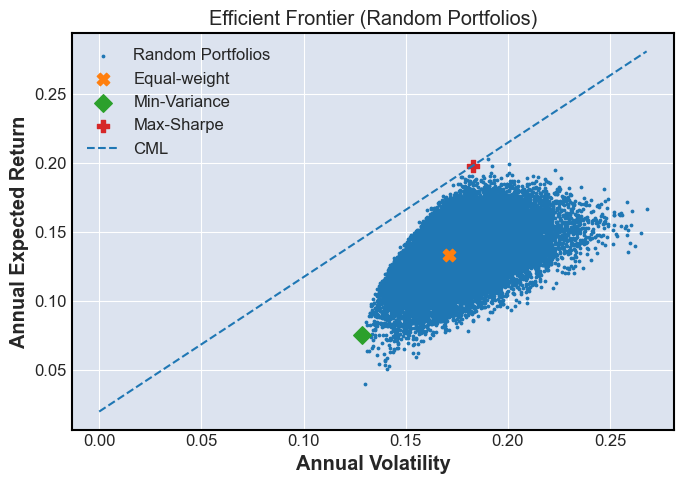

Betas:
 AAPL                   0.154149
AMAZN                  0.548344
CAT                    0.548344
JNJ                    0.055302
JPM                    0.320555
MSFT                   0.210040
PG                    -0.075803
XOM                   -0.183906
Portfolio_EQ           0.197128
Portfolio_MinVar       0.022197
Portfolio_MaxSharpe    0.101591
dtype: float64

Annualised returns:
 AAPL                   0.154977
AMAZN                  0.159809
CAT                    0.159809
JNJ                   -0.041770
JPM                    0.172981
MSFT                   0.114375
PG                     0.027898
XOM                    0.227934
Portfolio_EQ           0.122002
Portfolio_MinVar       0.067488
Portfolio_MaxSharpe    0.179755
dtype: float64

Market annual return (SP500): 0.08839706677600567


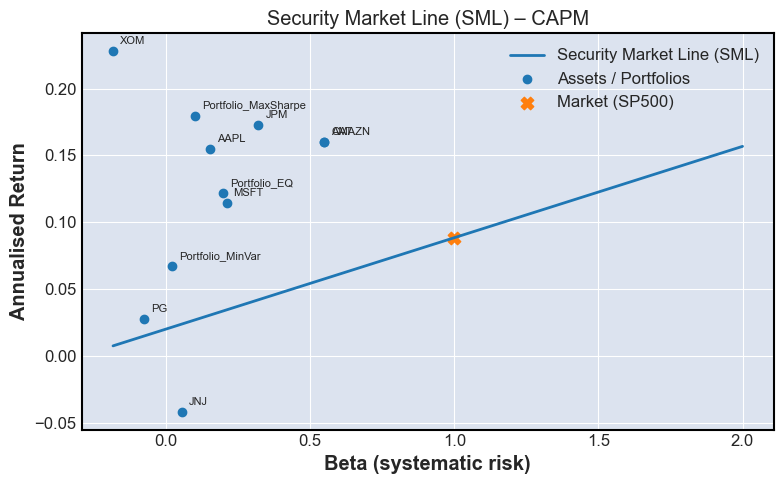

In [22]:
# ----------------------------------------------------
# 8. PLOTS (Efficient Frontier + Cumulative Returns)
# ----------------------------------------------------
# 8.1 Efficient frontier scatter + special portfolios
plt.figure(figsize=(7, 5))
plt.scatter(results_df["Volatility"], results_df["Return"], s=3, label="Random Portfolios")
plt.scatter(vol_eq,     ret_eq,     marker='X', s=80, label="Equal-weight")
plt.scatter(vol_minvar, ret_minvar, marker='D', s=80, label="Min-Variance")
plt.scatter(vol_maxshp, ret_maxshp, marker='P', s=80, label="Max-Sharpe")

plt.xlabel("Annual Volatility")
plt.ylabel("Annual Expected Return")
plt.title("Efficient Frontier (Random Portfolios)")
plt.legend()
plt.tight_layout()
plt.show()

# 8.2 Cumulative returns of £1 in each portfolio vs market proxy
cum_eq     = (1 + enriched_returns["Portfolio_EQ"]).cumprod()
cum_minvar = (1 + enriched_returns["Portfolio_MinVar"]).cumprod()
cum_maxshp = (1 + enriched_returns["Portfolio_MaxSharpe"]).cumprod()
cum_mkt    = (1 + enriched_returns["SP500"]).cumprod()

plt.figure(figsize=(8, 5))
plt.plot(cum_eq,     label="Equal-weight")
plt.plot(cum_minvar, label="Min-Variance")
plt.plot(cum_maxshp, label="Max-Sharpe")
plt.plot(cum_mkt,    label="SP500", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Portfolio Value (start = 1)")
plt.title("Cumulative Performance of Portfolios vs SP500")
plt.legend()
plt.tight_layout()
plt.show()



# ----------------------------------------------------
# 8. PLOTS (Efficient Frontier + Cumulative Returns)
# ----------------------------------------------------
# 8.1 Efficient frontier scatter + special portfolios
plt.figure(figsize=(7, 5))
plt.scatter(results_df["Volatility"], results_df["Return"], s=3, label="Random Portfolios")
plt.scatter(vol_eq,     ret_eq,     marker='X', s=80, label="Equal-weight")
plt.scatter(vol_minvar, ret_minvar, marker='D', s=80, label="Min-Variance")
plt.scatter(vol_maxshp, ret_maxshp, marker='P', s=80, label="Max-Sharpe")

# --- Capital Market Line (CML) ---
# Set/assume your annual risk-free rate here:
risk_free_rate = 0.02  # for example, 2%

# x-range for the CML (from 0 vol up to max observed vol)
max_vol = results_df["Volatility"].max()
cml_x = np.linspace(0, max_vol, 100)

# CML equation: E[R] = rf + ((E[R_m] - rf) / σ_m) * σ
cml_slope = (ret_maxshp - risk_free_rate) / vol_maxshp
cml_y = risk_free_rate + cml_slope * cml_x
plt.plot(cml_x, cml_y, linestyle="--", linewidth=1.5, label="CML")


plt.xlabel("Annual Volatility")
plt.ylabel("Annual Expected Return")
plt.title("Efficient Frontier (Random Portfolios)")
plt.legend()
plt.tight_layout()
plt.show()



# ----------------------------------------------------
# 8.3 Security Market Line (SML)
# ----------------------------------------------------
# Assumptions:
# - enriched_returns has columns:
#     assets (individual stocks),
#     "Portfolio_EQ", "Portfolio_MinVar", "Portfolio_MaxSharpe", "SP500"
# - returns are weekly (adjust periods_per_year if needed)

periods_per_year = 52                 # change to 12 for monthly, 252 for daily, etc.
rf_annual = risk_free_rate            # reuse your earlier risk-free rate
rf_period = (1 + rf_annual)**(1/periods_per_year) - 1

# Columns to include in SML (individual assets + your 3 portfolios)
cols_for_sml = assets + ["Portfolio_EQ", "Portfolio_MinVar", "Portfolio_MaxSharpe", "SP500"]

# Align and drop rows with missing values
sml_data = enriched_returns[cols_for_sml].dropna()

market = sml_data["SP500"]
excess_mkt = market - rf_period

betas = {}
ann_returns = {}

# Compute beta and annualised return for each asset/portfolio
for col in cols_for_sml:
    if col == "SP500":
        continue  # market handled separately

    r = sml_data[col]
    excess_r = r - rf_period

    # Beta_i = Cov(R_i - R_f, R_m - R_f) / Var(R_m - R_f)
    cov_im = np.cov(excess_r, excess_mkt, ddof=1)[0, 1]
    var_m  = np.var(excess_mkt, ddof=1)
    beta_i = cov_im / var_m

    betas[col] = beta_i

    # Annualised average return (simple approximation)
    ann_ret_i = r.mean() * periods_per_year
    ann_returns[col] = ann_ret_i

betas = pd.Series(betas)
ann_returns = pd.Series(ann_returns)

# Market annual return and risk premium
Rm_annual = market.mean() * periods_per_year
market_risk_premium = Rm_annual - rf_annual

print("Betas:\n", betas)
print("\nAnnualised returns:\n", ann_returns)
print("\nMarket annual return (SP500):", Rm_annual)

# Build SML line
beta_min = min(0, betas.min())
beta_max = max(2, betas.max())  # extend a bit beyond range for nicer plot
beta_line = np.linspace(beta_min, beta_max, 100)
sml_line = rf_annual + market_risk_premium * beta_line

# Plot SML + points
plt.figure(figsize=(8, 5))

# Security Market Line
plt.plot(beta_line, sml_line, label="Security Market Line (SML)")

# Assets + portfolios
plt.scatter(betas, ann_returns, label="Assets / Portfolios")

# Annotate each point
for name in betas.index:
    plt.annotate(name,
                 (betas[name], ann_returns[name]),
                 xytext=(5, 5),
                 textcoords="offset points",
                 fontsize=8)

# Market point (beta = 1, Rm)
plt.scatter(1.0, Rm_annual, marker="X", s=80, label="Market (SP500)")

plt.xlabel("Beta (systematic risk)")
plt.ylabel("Annualised Return")
plt.title("Security Market Line (SML) – CAPM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 📈 Interpretation of Cumulative Performance Plot

The chart compares the growth of **£1 invested** in four portfolios from early 2022 to the end of 2024:

- **Equal-Weight portfolio**  
- **Minimum-Variance portfolio**  
- **Maximum-Sharpe portfolio**  
- **S&P 500 benchmark**

---

## 🔹 1. Max-Sharpe Portfolio — Clear Outperformer

The **Max-Sharpe portfolio** shows the strongest performance across the entire period.

### Key observations:
- Experiences declines during market downturns (mid-2022, late-2023), but  
- **Recovers faster** and reaches new highs earlier than other portfolios  
- Ends around **£1.65–£1.70**, the highest cumulative value

**Interpretation:**  
➡️ The Max-Sharpe portfolio delivered the **highest risk-adjusted return** and achieved **superior compounding**, outperforming both the market and the other optimized portfolios.

---

## 🔹 2. Min-Variance Portfolio — Smooth and Stable Growth

The **Min-Variance portfolio** demonstrates:

- Smaller drawdowns during market corrections  
- Lower fluctuations  
- A steady, smooth upward trend, ending around **£1.30–£1.35**  

It does not grow as aggressively as Max-Sharpe but **still beats the S&P 500** during the sample period.

**Interpretation:**  
➡️ Min-Variance prioritizes **stability and reduced risk**, making it ideal for conservative investors.

---

## 🔹 3. Equal-Weight Portfolio — Middle of the Pack

The **Equal-Weight portfolio**:

- Underperforms Min-Variance early on  
- Tracks market volatility more closely  
- Shows strong recovery from mid-2023 onward  
- Ends slightly above Min-Variance at around **£1.40**

**Interpretation:**  
➡️ Equal-weighting provides **solid diversified performance**, with more volatility than Min-Variance and less efficiency than Max-Sharpe.

---

## 🔹 4. S&P 500 Benchmark — Lowest Performer in This Window

The **S&P 500 benchmark** shows:

- Deeper drawdowns (especially through the 2022 correction)  
- Slower recovery relative to the constructed portfolios  
- Final value around **£1.15–£1.20**, the lowest among all series

**Interpretation:**  
➡️ All three portfolios outperformed the S&P 500 over this sample period.  
This highlights the **diversification benefits** and effectiveness of mean–variance optimization during this market environment.

---

## 🎯 Overall Interpretation

- **Max-Sharpe** → Highest cumulative growth; decisive outperformer  
- **Min-Variance** → Steady, low-risk performance with minimal drawdowns  
- **Equal-Weight** → Balanced and diversified, moderate long-run growth  
- **S&P 500** → Weakest performer; deeper drawdowns and slower compounding



Turn weights_list into a matrix

Compute weekly returns for every random portfolio

Turn £1 into a cumulative value path for each

Plot them (probably as faint lines) plus your three main portfolios.

<class 'numpy.ndarray'>
            Portfolio_1  Portfolio_2  Portfolio_3  Portfolio_4  Portfolio_5  \
Date                                                                          
2022-01-07     1.023465     1.005865     1.015108     0.997014     0.993580   
2022-01-14     1.024199     1.001802     1.006938     0.988540     0.988065   
2022-01-21     0.969189     0.951404     0.954682     0.949473     0.917885   
2022-01-28     0.999545     0.972988     0.983272     0.968160     0.937737   
2022-02-04     1.050285     1.013880     1.025158     0.998438     0.990761   
...                 ...          ...          ...          ...          ...   
2024-11-29     1.478345     1.457158     1.418327     1.308543     1.330473   
2024-12-06     1.499789     1.485952     1.441271     1.323374     1.387271   
2024-12-13     1.490471     1.478274     1.427541     1.316471     1.381597   
2024-12-20     1.471060     1.457364     1.398462     1.300652     1.358247   
2024-12-27     1.474765     

/var/folders/7j/8pz9dqx16j514s66gfbnpf1r0000gn/T/ipykernel_1432/451680079.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


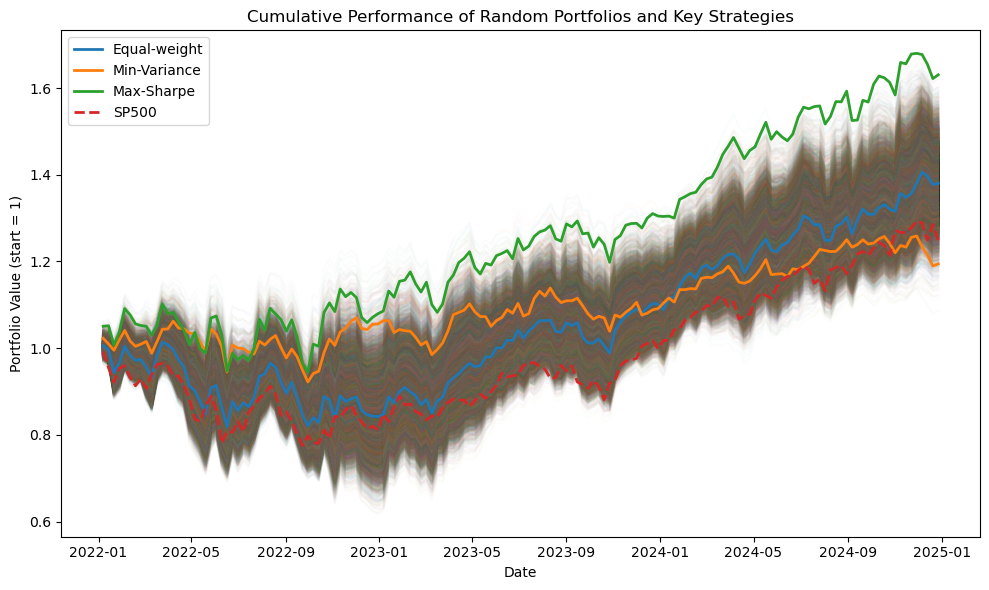

In [15]:

# 1️⃣ Compute cumulative performance for all random portfolios


# Matrix of random weights: shape (N, n_assets) N = 30000
W = np.vstack(weights_list)   # each row = one random portfolio's weights # (N, n_assets). 
# Asset returns matrix: shape (T, n_assets)
R = returns[tickers].values   # T = number of weeks # (T, n_assets)
rp_random = R @ W.T              # (T, N) all at once T rows each per week and N columns each column is the returns of one random portfolio

print(type(rp_random))

rp_random_df = pd.DataFrame(rp_random, index=returns.index, columns=[f'Portfolio_{i+1}' for i in range(rp_random.shape[1])])
# Cumulative performance of £1 in each random portfolio
cum_random = (1 + rp_random_df).cumprod()
print(cum_random)


# 2️⃣ Plot all random portfolios + your main ones
plt.figure(figsize=(10, 6))

# Plot all random portfolios as faint grey lines
plt.plot(cum_random.index, cum_random.values, alpha=0.02)  # very low alpha so it doesn't dominate

# Overlay your three key portfolios + benchmark
plt.plot(cum_eq.index,     cum_eq.values,     label="Equal-weight",   linewidth=2)
plt.plot(cum_minvar.index, cum_minvar.values, label="Min-Variance",   linewidth=2)
plt.plot(cum_maxshp.index, cum_maxshp.values, label="Max-Sharpe",     linewidth=2)
plt.plot(cum_mkt.index,    cum_mkt.values,    label='SP500',    linewidth=2, linestyle="--")

plt.xlabel("Date")
plt.ylabel("Portfolio Value (start = 1)")
plt.title("Cumulative Performance of Random Portfolios and Key Strategies")
plt.legend()
plt.tight_layout()
plt.show()



“We simulate the cumulative performance of all randomly generated portfolios used in the efficient frontier approximation. The key strategies (equal-weight, minimum-variance, and maximum-Sharpe) are then overlaid, illustrating how these optimised portfolios compare to the wider universe of feasible allocations

/var/folders/7j/8pz9dqx16j514s66gfbnpf1r0000gn/T/ipykernel_1432/1812648095.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda = yf.download("NVDA", period="5y")
[*********************100%***********************]  1 of 1 completed


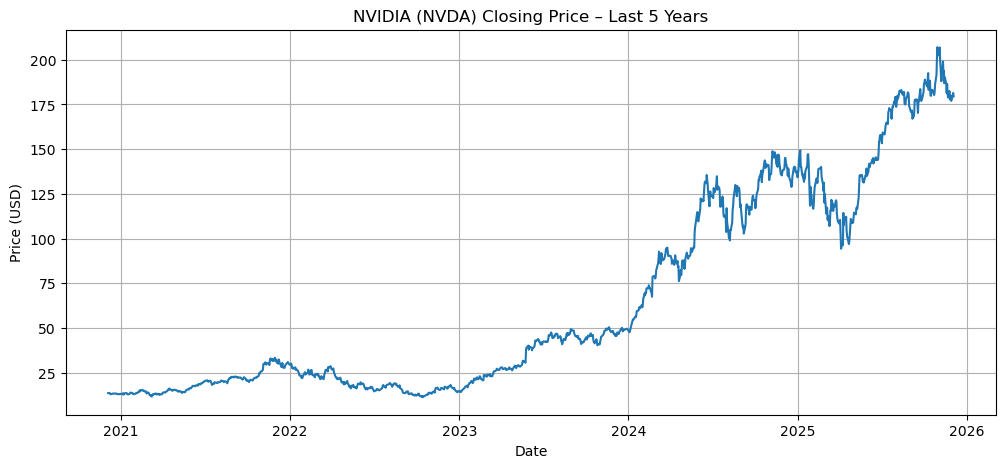

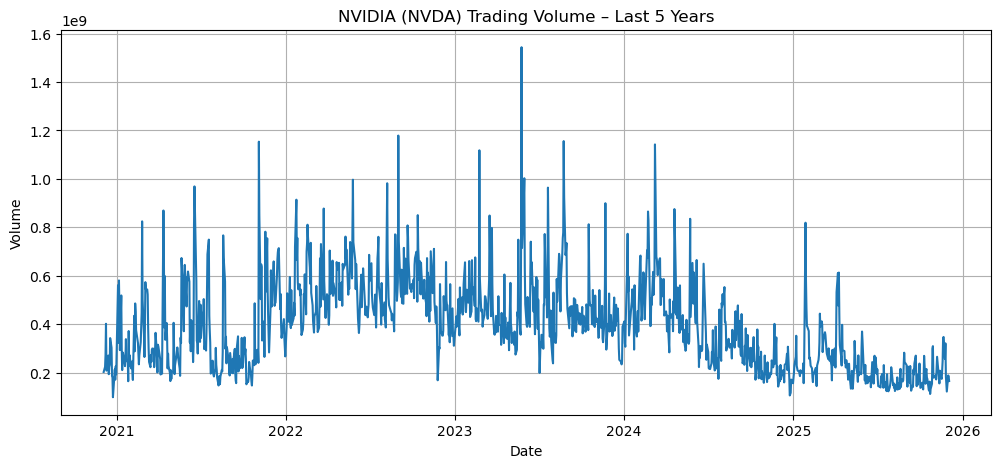

/opt/anaconda3/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


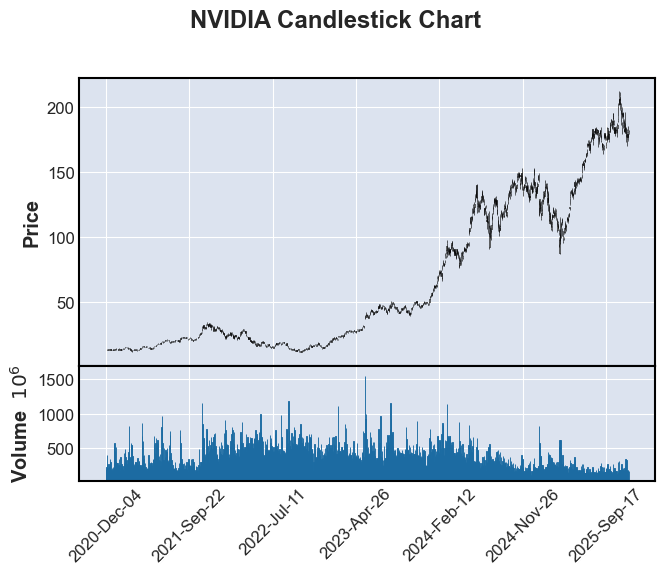

In [16]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf

# Download NVIDIA stock data for the last 2 years
nvda = yf.download("NVDA", period="5y")

# ---- 0. FLATTEN MULTIINDEX COLUMNS IF NEEDED ----
# If columns look like ('Open', 'NVDA'), ('High', 'NVDA'), ...
if isinstance(nvda.columns, pd.MultiIndex):
    # Keep just the first level: Open, High, Low, Close, Adj Close, Volume
    nvda.columns = nvda.columns.get_level_values(0)

# ---------- CLEAN THE DATA FOR mplfinance ----------
ohlc_cols = ["Open", "High", "Low", "Close"]

# Make sure OHLC are numeric
nvda[ohlc_cols] = nvda[ohlc_cols].apply(pd.to_numeric, errors="coerce")

# Drop rows where any OHLC value is NaN
nvda = nvda.dropna(subset=ohlc_cols)

# (Optional) remove timezone info from index if present
if getattr(nvda.index, "tz", None) is not None:
    nvda.index = nvda.index.tz_localize(None)

# ---- 1. Closing Price Plot ----
plt.figure(figsize=(12, 5))
plt.plot(nvda['Close'])
plt.title("NVIDIA (NVDA) Closing Price – Last 5 Years")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

# ---- 2. Volume Plot ----
plt.figure(figsize=(12, 5))
plt.plot(nvda['Volume'])
plt.title("NVIDIA (NVDA) Trading Volume – Last 5 Years")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.show()

# ---- 3. Candlestick Plot ----
mpf.plot(
    nvda,
    type='candle',
    volume=True,
    title="NVIDIA Candlestick Chart"
)


Using expiry: 2025-12-05

First few put contracts:
        contractSymbol             lastTradeDate  strike  lastPrice  bid  ask  \
0  NVDA251205P00050000 2025-12-02 18:45:44+00:00    50.0       0.01  0.0  0.0   
1  NVDA251205P00055000 2025-11-18 17:14:43+00:00    55.0       0.01  0.0  0.0   
2  NVDA251205P00060000 2025-11-21 18:59:34+00:00    60.0       0.01  0.0  0.0   
3  NVDA251205P00065000 2025-12-02 17:58:10+00:00    65.0       0.01  0.0  0.0   
4  NVDA251205P00070000 2025-11-25 19:46:28+00:00    70.0       0.01  0.0  0.0   

   change  percentChange  volume  openInterest  impliedVolatility  inTheMoney  \
0     0.0            0.0     1.0            10           0.500005       False   
1     0.0            0.0   100.0           325           0.500005       False   
2     0.0            0.0    26.0            61           0.500005       False   
3     0.0            0.0     1.0            90           0.500005       False   
4     0.0            0.0     1.0            66           

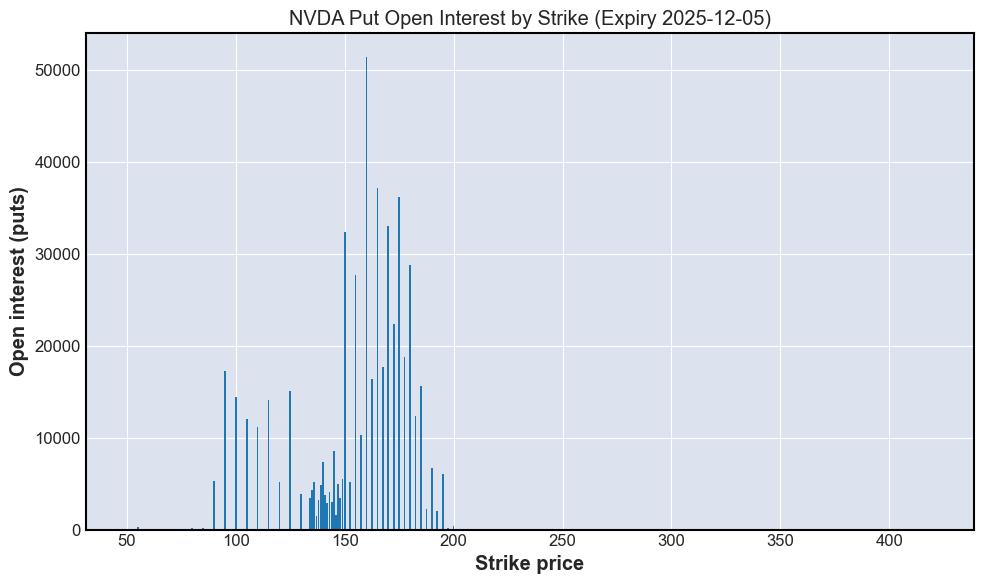

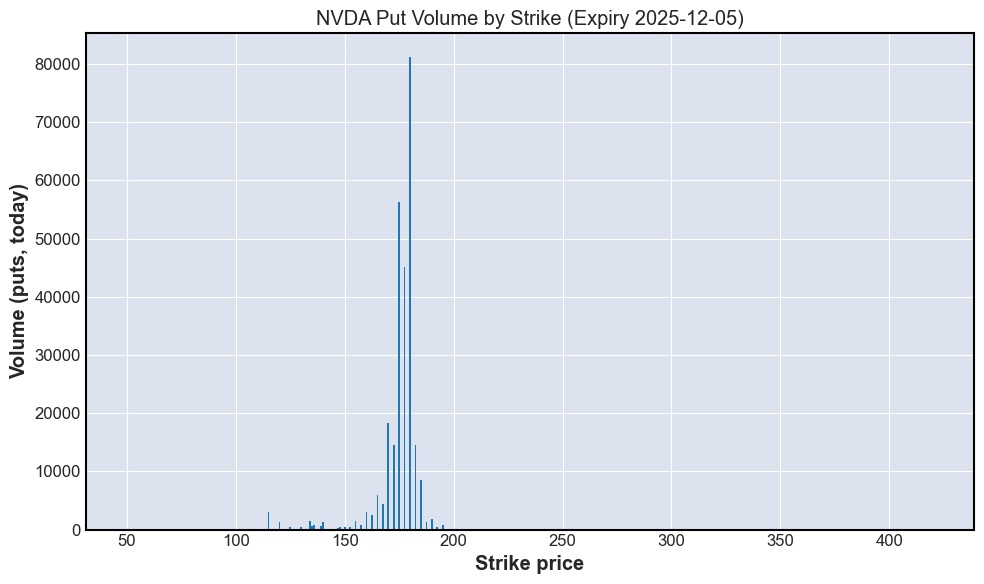

In [17]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd


# ========= CONFIG =========
TICKER = "NVDA"       # change if you want another stock
USE_NEAREST_EXPIRY = True
MANUAL_EXPIRY = "2025-01-17"  # only used if USE_NEAREST_EXPIRY = False
# ==========================


def main():
    ticker = yf.Ticker(TICKER)

    # Get all available option expirations
    expirations = ticker.options
    if not expirations:
        print(f"No options data found for {TICKER}.")
        return

    if USE_NEAREST_EXPIRY:
        expiry = expirations[0]   # nearest expiration date
    else:
        expiry = MANUAL_EXPIRY
        if expiry not in expirations:
            print(f"Chosen expiry {expiry} not in available expirations:")
            for e in expirations:
                print("  ", e)
            return

    print(f"Using expiry: {expiry}")
    print()

    # Fetch option chain for that expiry
    opt_chain = ticker.option_chain(expiry)
    puts = opt_chain.puts  # DataFrame of all puts
    calls = opt_chain.calls  # (available if you want it)

    # Basic preview
    print("First few put contracts:")
    print(puts.head())
    print()
    print("Columns:", list(puts.columns))
    print()

    # --- Plot 1: Open interest by strike (puts) ---
    if "openInterest" in puts.columns:
        plt.figure(figsize=(10, 6))
        plt.bar(puts["strike"], puts["openInterest"])
        plt.xlabel("Strike price")
        plt.ylabel("Open interest (puts)")
        plt.title(f"{TICKER} Put Open Interest by Strike (Expiry {expiry})")
        plt.tight_layout()
        plt.show()
    else:
        print("No openInterest column found in puts DataFrame.")

    # --- Plot 2: Volume by strike (puts) ---
    if "volume" in puts.columns:
        plt.figure(figsize=(10, 6))
        plt.bar(puts["strike"], puts["volume"])
        plt.xlabel("Strike price")
        plt.ylabel("Volume (puts, today)")
        plt.title(f"{TICKER} Put Volume by Strike (Expiry {expiry})")
        plt.tight_layout()
        plt.show()
    else:
        print("No volume column found in puts DataFrame.")


if __name__ == "__main__":
    main()


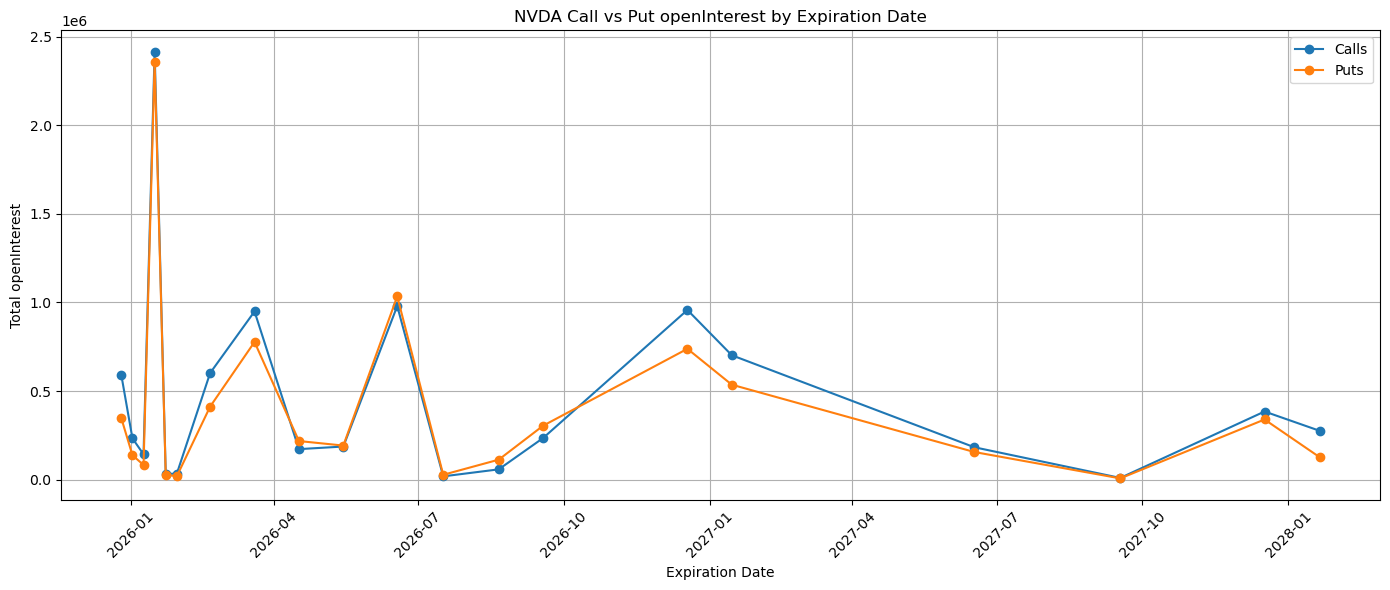

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

# ========== CONFIG ==========
TICKER = "NVDA"
PLOT_COLUMN = "openInterest"   # can also use "volume"
# ============================

def main():
    ticker = yf.Ticker(TICKER)
    expirations = ticker.options

    if not expirations:
        print("No option data found.")
        return

    call_data = []
    put_data = []

    for expiry in expirations:
        chain = ticker.option_chain(expiry)
        calls = chain.calls
        puts = chain.puts

        # Sum the chosen metric (OI or volume)
        total_calls = calls[PLOT_COLUMN].fillna(0).sum()
        total_puts  = puts[PLOT_COLUMN].fillna(0).sum()

        call_data.append({"expiry": expiry, PLOT_COLUMN: total_calls})
        put_data.append({"expiry": expiry, PLOT_COLUMN: total_puts})

    # Convert to DataFrames
    df_calls = pd.DataFrame(call_data)
    df_puts  = pd.DataFrame(put_data)

    # Convert expiry strings → datetime
    df_calls["expiry"] = pd.to_datetime(df_calls["expiry"])
    df_puts["expiry"]  = pd.to_datetime(df_puts["expiry"])

    # Sort by date
    df_calls = df_calls.sort_values("expiry")
    df_puts  = df_puts.sort_values("expiry")

    # ====== PLOT ======
    plt.figure(figsize=(14, 6))

    plt.plot(df_calls["expiry"], df_calls[PLOT_COLUMN], marker="o", label="Calls")
    plt.plot(df_puts["expiry"],  df_puts[PLOT_COLUMN],  marker="o", label="Puts")

    plt.title(f"{TICKER} Call vs Put {PLOT_COLUMN} by Expiration Date")
    plt.xlabel("Expiration Date")
    plt.ylabel(f"Total {PLOT_COLUMN}")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    plt.show()

if __name__ == "__main__":
    main()


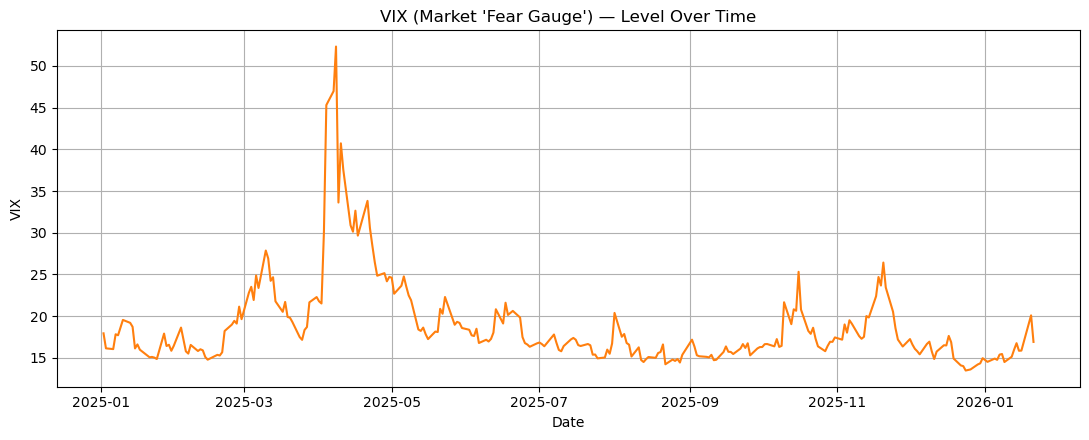

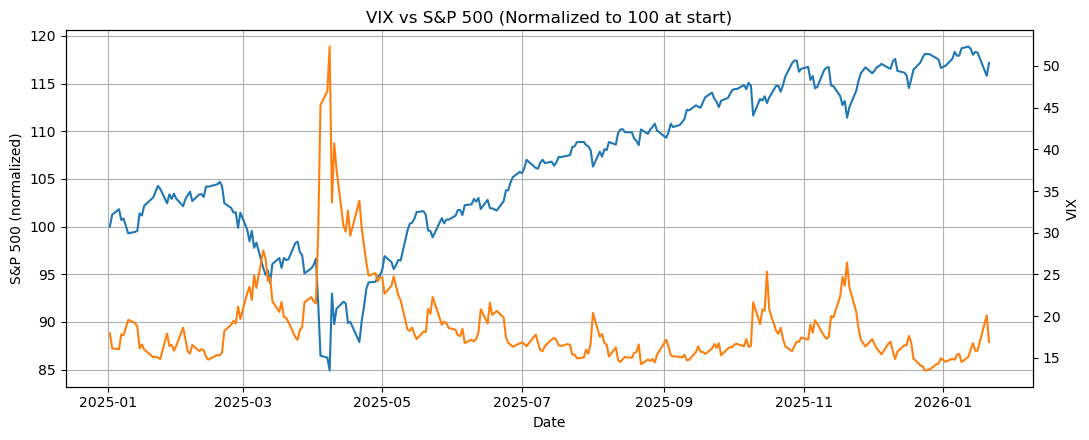

Days with VIX > 30: 12
Days with VIX > 40: 4
Most recent VIX: 16.899999618530273


In [7]:
# 1) VIX Index (the classic “fear gauge”)

# pip install yfinance pandas matplotlib

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Tickers:
#   ^VIX  = CBOE Volatility Index
#   ^GSPC = S&P 500 index (SPX proxy)
tickers = ["^VIX", "^GSPC"]

# Download daily data
start = "2025-01-01"
df = yf.download(tickers, start=start, auto_adjust=True, progress=False)["Close"]
df = df.dropna()

vix = df["^VIX"]
spx = df["^GSPC"]

# Optional: normalize SPX to 100 so it can be compared visually
spx_norm = (spx / spx.iloc[0]) * 100

# --- Plot 1: VIX level over time ---
plt.figure(figsize=(11, 4.5))
plt.plot(vix.index, vix.values,color="tab:orange", label="VIX")
plt.title("VIX (Market 'Fear Gauge') — Level Over Time")
plt.xlabel("Date")
plt.ylabel("VIX")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: VIX vs SPX on same chart (dual axis) ---
fig, ax1 = plt.subplots(figsize=(11, 4.5))

#ax1.plot(spx_norm.index, spx_norm.values)
ax1.plot(spx_norm.index, spx_norm.values, color="tab:blue", label="S&P 500 (normalized)")

ax1.set_title("VIX vs S&P 500 (Normalized to 100 at start)")
ax1.set_xlabel("Date")
ax1.set_ylabel("S&P 500 (normalized)")
ax1.grid(True)

ax2 = ax1.twinx()
#ax2.plot(vix.index, vix.values)
ax2.plot(vix.index, vix.values, color="tab:orange", label="VIX")
ax2.set_ylabel("VIX")

plt.tight_layout()
plt.show()

# --- (Optional) quick “stress flags” ---
# Days where VIX is elevated
flags = pd.DataFrame({"VIX": vix})
flags["VIX>30"] = flags["VIX"] > 30
flags["VIX>40"] = flags["VIX"] > 40
print("Days with VIX > 30:", int(flags["VIX>30"].sum()))
print("Days with VIX > 40:", int(flags["VIX>40"].sum()))
print("Most recent VIX:", float(vix.iloc[-1]))



2) VIX level interpretation

Rough guide:

VIX < 15 → very calm / complacent

VIX 15–20 → mild caution

VIX 20–30 → real nervousness

VIX > 30 → panic conditions

From your chart:

VIX spent most of the time around 15–18
→ Normal to mildly cautious.

It briefly spiked above ~20
→ That’s a legit “risk-off” signal, not full panic, but a clear fear event.